# Case 2 (1) Long-Short Portfolio strategy by Market Capitalization

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib.pyplot import MultipleLocator
import statsmodels.formula.api as sm

## 导入数据与数据预处理

In [2]:
df = pd.read_csv(r'D:\Code Library\FIN3080\Project 2\case 2 part 1\个股月度回报率\TRD_Mnth.csv')
df

,Stkcd,Trdmnt,Msmvttl,Mretwd
0,1,2006-01,12355970.65,0.034202
1,1,2006-02,13309423.50,0.077165
2,1,2006-03,12394887.09,-0.068713
3,1,2006-04,15333078.53,0.237049
4,1,2006-05,17084318.47,0.114213
...,...,...,...,...
392030,605599,2021-11,9636666.94,0.061697
392031,605599,2021-12,10468889.19,0.086360
392032,605599,2022-01,9247778.04,-0.116642
392033,605599,2022-02,10227778.07,0.105971


In [3]:
df['Trdmnt'] = pd.to_datetime(df['Trdmnt']).dt.to_period('M') # 生成datetime时间戳
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392035 entries, 0 to 392034
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype    
---  ------   --------------   -----    
 0   Stkcd    392035 non-null  int64    
 1   Trdmnt   392035 non-null  period[M]
 2   Msmvttl  392035 non-null  float64  
 3   Mretwd   390193 non-null  float64  
dtypes: float64(2), int64(1), period[M](1)
memory usage: 12.0 MB


In [4]:
stock_id = df.loc[df.Trdmnt == '2007-01','Stkcd'] # 选取2007-01及之前已上市的股票
df1 = df.loc[df.Stkcd.isin(stock_id)]
df1['Msmvttl'] = df1.groupby('Stkcd').Msmvttl.shift(1) # 将市值数据向下移动一格作为分组依据
df1 = df1[df1.Trdmnt >= '2007-01']
df1 = df1.sort_values(['Stkcd','Trdmnt'])
df1 = df1.dropna().reset_index(drop = True)
df1

<ipython-input-4-57cc55fd74fd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Msmvttl'] = df1.groupby('Stkcd').Msmvttl.shift(1) # 将市值数据向下移动一格作为分组依据


,Stkcd,Trdmnt,Msmvttl,Mretwd
0,1,2007-01,28156046.50,0.322046
1,1,2007-02,37223577.71,-0.004182
2,1,2007-03,37067911.94,-0.008924
3,1,2007-04,36737122.17,0.374470
4,1,2007-05,50494084.77,0.105588
...,...,...,...,...
217508,601991,2021-11,33717362.37,-0.069853
217509,601991,2021-12,31362105.44,0.280632
217510,601991,2022-01,40163328.70,-0.185185
217511,601991,2022-02,32725675.24,0.075758


## 根据市值大小进行分组

In [5]:
perc = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # 生成百分位数，以此分组
df1['allo'] = 1 # 生成新列供存储数据
df1

,Stkcd,Trdmnt,Msmvttl,Mretwd,allo
0,1,2007-01,28156046.50,0.322046,1
1,1,2007-02,37223577.71,-0.004182,1
2,1,2007-03,37067911.94,-0.008924,1
3,1,2007-04,36737122.17,0.374470,1
4,1,2007-05,50494084.77,0.105588,1
...,...,...,...,...,...
217508,601991,2021-11,33717362.37,-0.069853,1
217509,601991,2021-12,31362105.44,0.280632,1
217510,601991,2022-01,40163328.70,-0.185185,1
217511,601991,2022-02,32725675.24,0.075758,1


In [6]:
def allocation(df): # 构造函数，使得每个公司按照当月市值进行区间排名（排名分0-9，0代表市值最小的公司）
    quan = df['Msmvttl'].describe(percentiles = perc)
    quan = quan.iloc[4:13]
    df.loc[df.Msmvttl <= quan[0],'allo'] = 0
    df.loc[(df.Msmvttl > quan[0])&(df.Msmvttl <= quan[1]),'allo'] = 1
    df.loc[(df.Msmvttl > quan[1])&(df.Msmvttl <= quan[2]),'allo'] = 2
    df.loc[(df.Msmvttl > quan[2])&(df.Msmvttl <= quan[3]),'allo'] = 3
    df.loc[(df.Msmvttl > quan[3])&(df.Msmvttl <= quan[4]),'allo'] = 4
    df.loc[(df.Msmvttl > quan[4])&(df.Msmvttl <= quan[5]),'allo'] = 5
    df.loc[(df.Msmvttl > quan[5])&(df.Msmvttl <= quan[6]),'allo'] = 6
    df.loc[(df.Msmvttl > quan[6])&(df.Msmvttl <= quan[7]),'allo'] = 7
    df.loc[(df.Msmvttl > quan[7])&(df.Msmvttl <= quan[8]),'allo'] = 8
    df.loc[df.Msmvttl > quan[8],'allo'] = 9
    return df

In [7]:
df1 = df1.groupby(['Trdmnt']).apply(allocation) # 按时间分组进行排名
df1

,Stkcd,Trdmnt,Msmvttl,Mretwd,allo
0,1,2007-01,28156046.50,0.322046,9
1,1,2007-02,37223577.71,-0.004182,9
2,1,2007-03,37067911.94,-0.008924,9
3,1,2007-04,36737122.17,0.374470,9
4,1,2007-05,50494084.77,0.105588,9
...,...,...,...,...,...
217508,601991,2021-11,33717362.37,-0.069853,8
217509,601991,2021-12,31362105.44,0.280632,8
217510,601991,2022-01,40163328.70,-0.185185,8
217511,601991,2022-02,32725675.24,0.075758,8


In [8]:
ew_portfolio = df1.groupby(['allo','Trdmnt']).agg({'Mretwd':'mean'}) # 平均取每个投资组合当月的收益率
ew_portfolio = ew_portfolio.reset_index()
ew_portfolio = ew_portfolio.rename(columns = {'Trdmnt':'ym'})
ew_portfolio

,allo,ym,Mretwd
0,0,2007-01,0.234364
1,0,2007-02,0.252308
2,0,2007-03,0.284614
3,0,2007-04,0.354518
4,0,2007-05,0.139155
...,...,...,...
1825,9,2021-11,-0.015298
1826,9,2021-12,0.037432
1827,9,2022-01,-0.091783
1828,9,2022-02,0.034941


In [9]:
result = ew_portfolio.groupby('allo').agg({'Mretwd':'mean'}).reset_index()
result

,allo,Mretwd
0,0,0.034991
1,1,0.023638
2,2,0.021626
3,3,0.016687
4,4,0.015062
5,5,0.014336
6,6,0.012365
7,7,0.011821
8,8,0.009552
9,9,0.007609


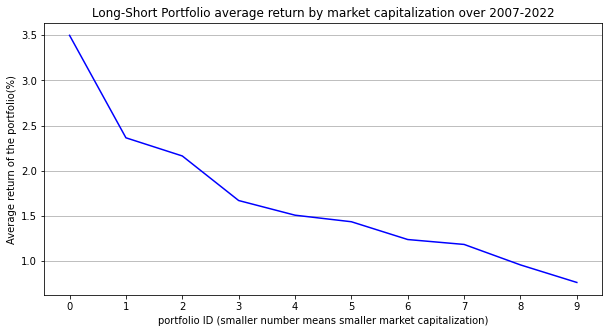

In [10]:
plt.figure(1, figsize = [10,5])
plt.plot(result.allo, result.Mretwd*100,'b')
plt.xlabel('portfolio ID (smaller number means smaller market capitalization)')
plt.ylabel('Average return of the portfolio(%)')
plt.title('Long-Short Portfolio average return by market capitalization over 2007-2022')
x_major_locator=MultipleLocator(1)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.grid(axis = 'y')
plt.show()

## 公司市值策略
结论：从长期（10年以上的投资期限）来看，小市值股票回报率高于大市值股票回报率

适用条件：
   * 1. 不买ST股票，因其波动性过大，可能退市（在本题数据源中已经剔除）
    
   * 2. 等权买入股票构建投资组合
    
   * 3. 长期持有（10年以上）

## CAPM模型以及多空投资组合构建

### 本题所用市场收益率为中证800指数，无风险利率为Shibor利率（换算成月利率）

In [11]:
reg = pd.read_csv(r'D:\Code Library\FIN3080\Project 2\case 2 part 1\capm_reg.csv') # 数据预处理
reg = reg.rename(columns = {'Month':'ym'})
reg['ym'] = pd.to_datetime(reg.ym).dt.to_period('M')
reg

,ym,rm,rf
0,2007-01,0.000000,0.001246
1,2007-02,0.091203,0.001888
2,2007-03,0.110805,0.001292
3,2007-04,0.293472,0.001974
4,2007-05,0.101181,0.001517
...,...,...,...
178,2021-11,-0.003992,0.001621
179,2021-12,0.020264,0.001577
180,2022-01,-0.083353,0.001568
181,2022-02,0.012716,0.001661


In [12]:
capm = pd.merge(reg, ew_portfolio, how = 'outer', on = 'ym') #与等权投资组合数据合并
capm

,ym,rm,rf,allo,Mretwd
0,2007-01,0.000000,0.001246,0,0.234364
1,2007-01,0.000000,0.001246,1,0.268139
2,2007-01,0.000000,0.001246,2,0.265669
3,2007-01,0.000000,0.001246,3,0.267305
4,2007-01,0.000000,0.001246,4,0.265699
...,...,...,...,...,...
1825,2022-03,-0.078057,0.001627,5,-0.018307
1826,2022-03,-0.078057,0.001627,6,-0.031055
1827,2022-03,-0.078057,0.001627,7,-0.061845
1828,2022-03,-0.078057,0.001627,8,-0.066455


In [13]:
capm = capm.sort_values(['ym','allo'])
capm = capm[(capm.allo == 0) | (capm.allo == 9)].reset_index(drop = True) # 选取最高回报率组合与最低回报率组合
capm

,ym,rm,rf,allo,Mretwd
0,2007-01,0.000000,0.001246,0,0.234364
1,2007-01,0.000000,0.001246,9,0.185277
2,2007-02,0.091203,0.001888,0,0.252308
3,2007-02,0.091203,0.001888,9,0.079230
4,2007-03,0.110805,0.001292,0,0.284614
...,...,...,...,...,...
361,2022-01,-0.083353,0.001568,9,-0.091783
362,2022-02,0.012716,0.001661,0,0.074095
363,2022-02,0.012716,0.001661,9,0.034941
364,2022-03,-0.078057,0.001627,0,0.068358


In [14]:
capm['sft_ret'] = capm.Mretwd.shift(1) # 将最低回报率组合的回报率向下移动一格
capm['ls_ret'] = capm['sft_ret'] - capm['Mretwd'] # 高回报率组合回报率减去低回报率组合回报率
capm = capm.groupby('ym').agg({'ls_ret':'last','rm':'last','rf':'last'}).reset_index() # 多空投资组合的净收益率取每个时间段第二个值
capm

,ym,ls_ret,rm,rf
0,2007-01,0.049087,0.000000,0.001246
1,2007-02,0.173078,0.091203,0.001888
2,2007-03,0.196389,0.110805,0.001292
3,2007-04,0.066854,0.293472,0.001974
4,2007-05,0.007418,0.101181,0.001517
...,...,...,...,...
178,2021-11,0.092833,-0.003992,0.001621
179,2021-12,0.063089,0.020264,0.001577
180,2022-01,0.068235,-0.083353,0.001568
181,2022-02,0.039154,0.012716,0.001661


In [15]:
capm['y'] = capm.ls_ret - capm.rf # 生成回归因变量
capm['x'] = capm.rm - capm.rf  # 生成回归自变量
capm = capm[['ym','y','x']]
capm

,ym,y,x
0,2007-01,0.047842,-0.001246
1,2007-02,0.171189,0.089315
2,2007-03,0.195097,0.109513
3,2007-04,0.064881,0.291498
4,2007-05,0.005901,0.099664
...,...,...,...
178,2021-11,0.091211,-0.005613
179,2021-12,0.061512,0.018687
180,2022-01,0.066667,-0.084921
181,2022-02,0.037493,0.011055


### 多空投资组合CAPM模型alpha预测结果

In [16]:
ls_pf = sm.ols(formula = 'y~x', data = capm).fit() # 回归分析及结果
ls_pf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.172
Date:                Wed, 20 Apr 2022   Prob (F-statistic):              0.280
Time:                        21:32:51   Log-Likelihood:                 225.50
No. Observations:                 183   AIC:                            -447.0
Df Residuals:                     181   BIC:                            -440.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0251      0.005      4.779      0.000       0.015       0.035
x              0.0688      0.064      1.083      0.280      -0.057       0.194
==============================================================================
Omnibus:                       17.246   Durbin-Watson:                   1.737
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.768
Skew:                           0.198   Prob(JB):                     1.28e-12
Kurtosis:                       5.650   Cond. No.                         12.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""